Dependencies:

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

Dataset:

In [5]:
df = pd.read_csv('C:/Users/Administrator/Desktop/DS Projects/DS Projects DataFiles/P5/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


1) Data Cleaning & Preprocessing

In [12]:
print(df.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


Since there are no missing values, hence, we move on to label encoding

In [13]:
df['Revenue'] = df['Revenue'].astype(int)

categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

le = LabelEncoder()
df['VisitorType'] = le.fit_transform(df['VisitorType'])
df['Weekend'] = le.fit_transform(df['Weekend'])

# Using One-Hot Encoding for (Month, OperatingSystems, Browser, Region, TrafficType)
df = pd.get_dummies(df, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType'], drop_first=True)

In [14]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# We use StandardScaler (important for models like XGBoost)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [15]:
df.shape

(12330, 68)

2) EDA

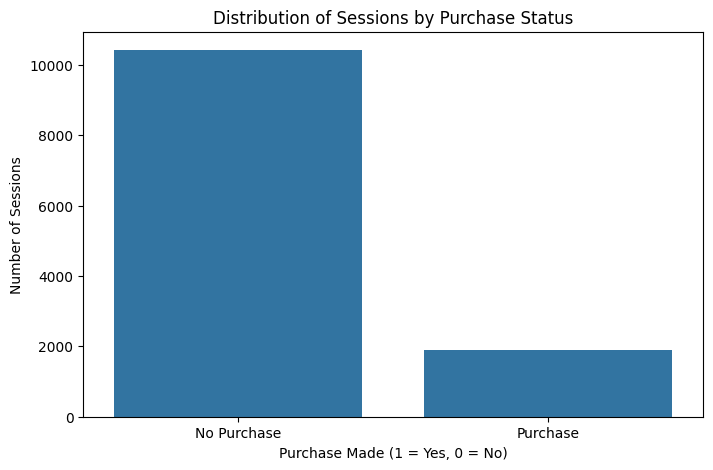

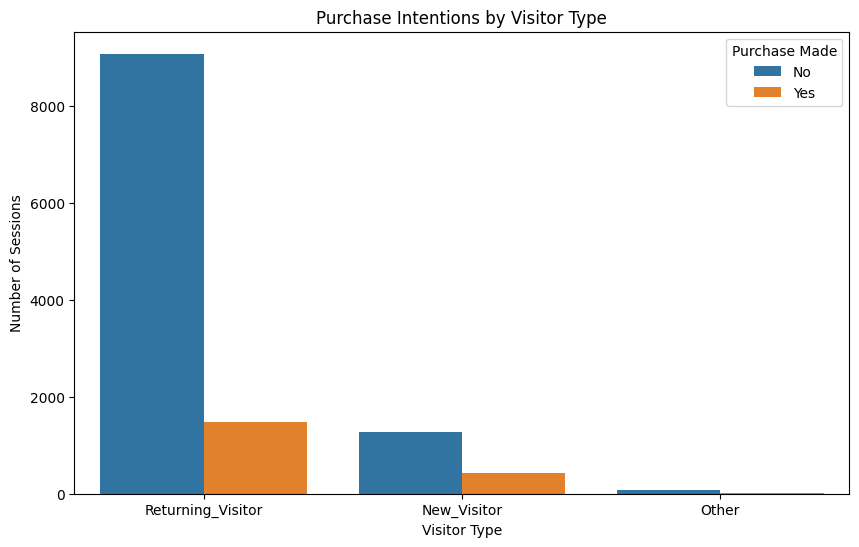

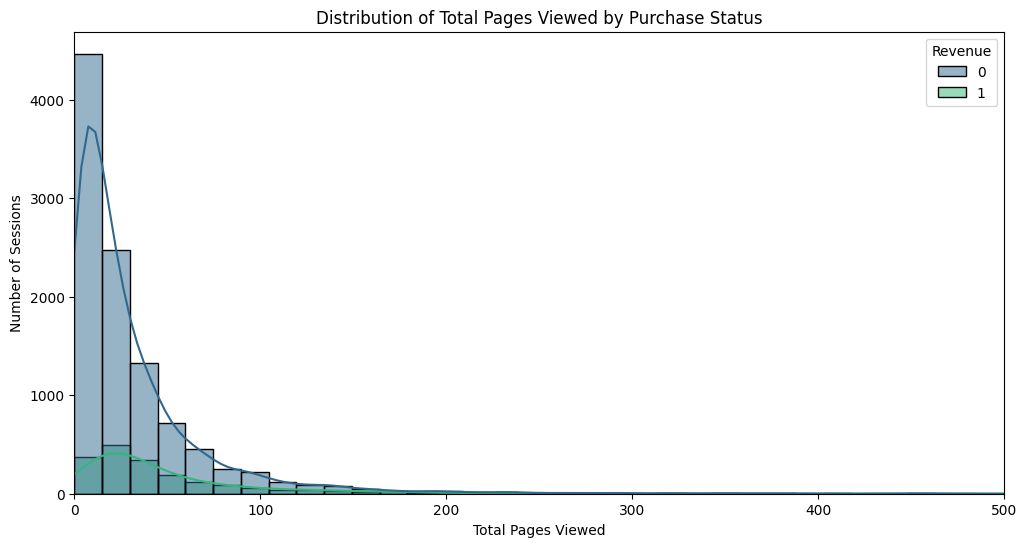

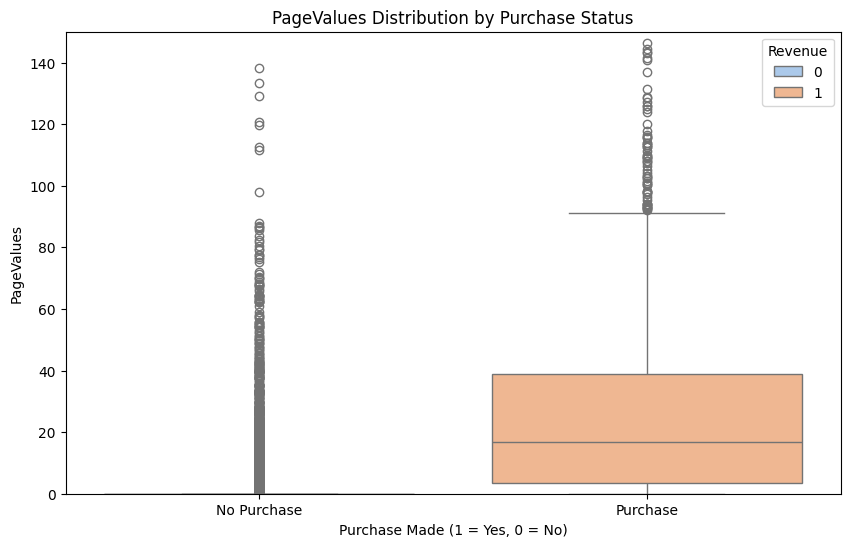

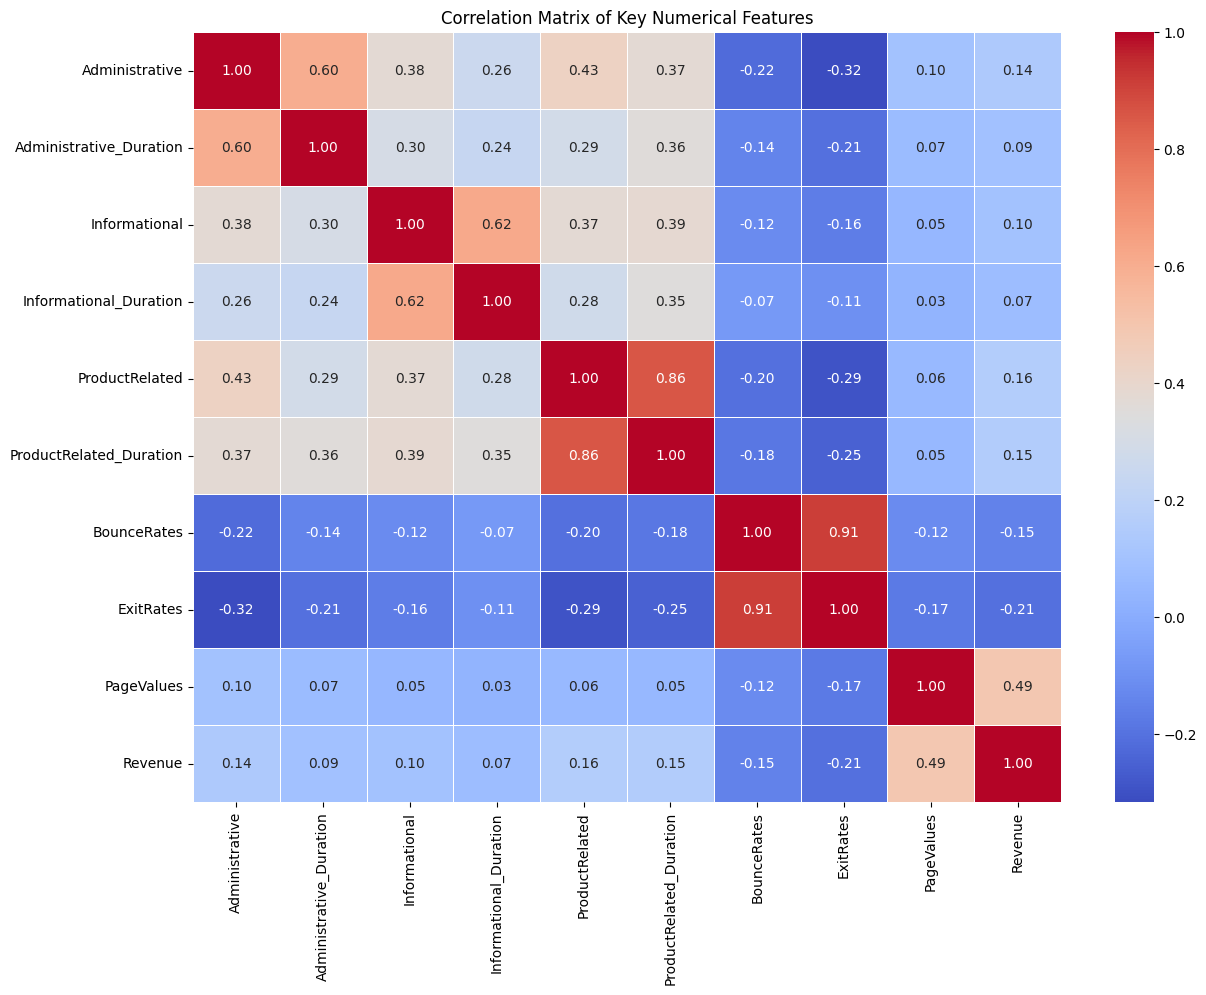

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Revenue', data=df)
plt.title('Distribution of Sessions by Purchase Status')
plt.xlabel('Purchase Made (1 = Yes, 0 = No)')
plt.ylabel('Number of Sessions')
plt.xticks(ticks=[0, 1], labels=['No Purchase', 'Purchase'])
plt.show()

# We need to map the encoded VisitorType back to its original meaning for a more intuitive chart.
df_viz = df.copy()
df_viz['VisitorType'] = df_viz['VisitorType'].map({0: 'New_Visitor', 1: 'Other', 2: 'Returning_Visitor'})
plt.figure(figsize=(10, 6))
sns.countplot(x='VisitorType', hue='Revenue', data=df_viz)
plt.title('Purchase Intentions by Visitor Type')
plt.xlabel('Visitor Type')
plt.ylabel('Number of Sessions')
plt.legend(title='Purchase Made', labels=['No', 'Yes'])
plt.show()

df['TotalPagesViewed'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='TotalPagesViewed', hue='Revenue', kde=True, bins=50, palette='viridis')
plt.title('Distribution of Total Pages Viewed by Purchase Status')
plt.xlabel('Total Pages Viewed')
plt.ylabel('Number of Sessions')
plt.xlim(0, 500) 
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Revenue', y='PageValues', data=df, hue='Revenue', palette='pastel')
plt.title('PageValues Distribution by Purchase Status')
plt.xlabel('Purchase Made (1 = Yes, 0 = No)')
plt.ylabel('PageValues')
plt.xticks(ticks=[0, 1], labels=['No Purchase', 'Purchase'])
plt.ylim(0, 150)
plt.show()

numerical_features = [
    'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
    'PageValues', 'Revenue'
]
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()

3) Modeling with XGBoost

Splitting data into training and testing sets (80/20 split)
Performing hyperparameter tuning with GridSearchCV
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best ROC-AUC score:
 0.9323


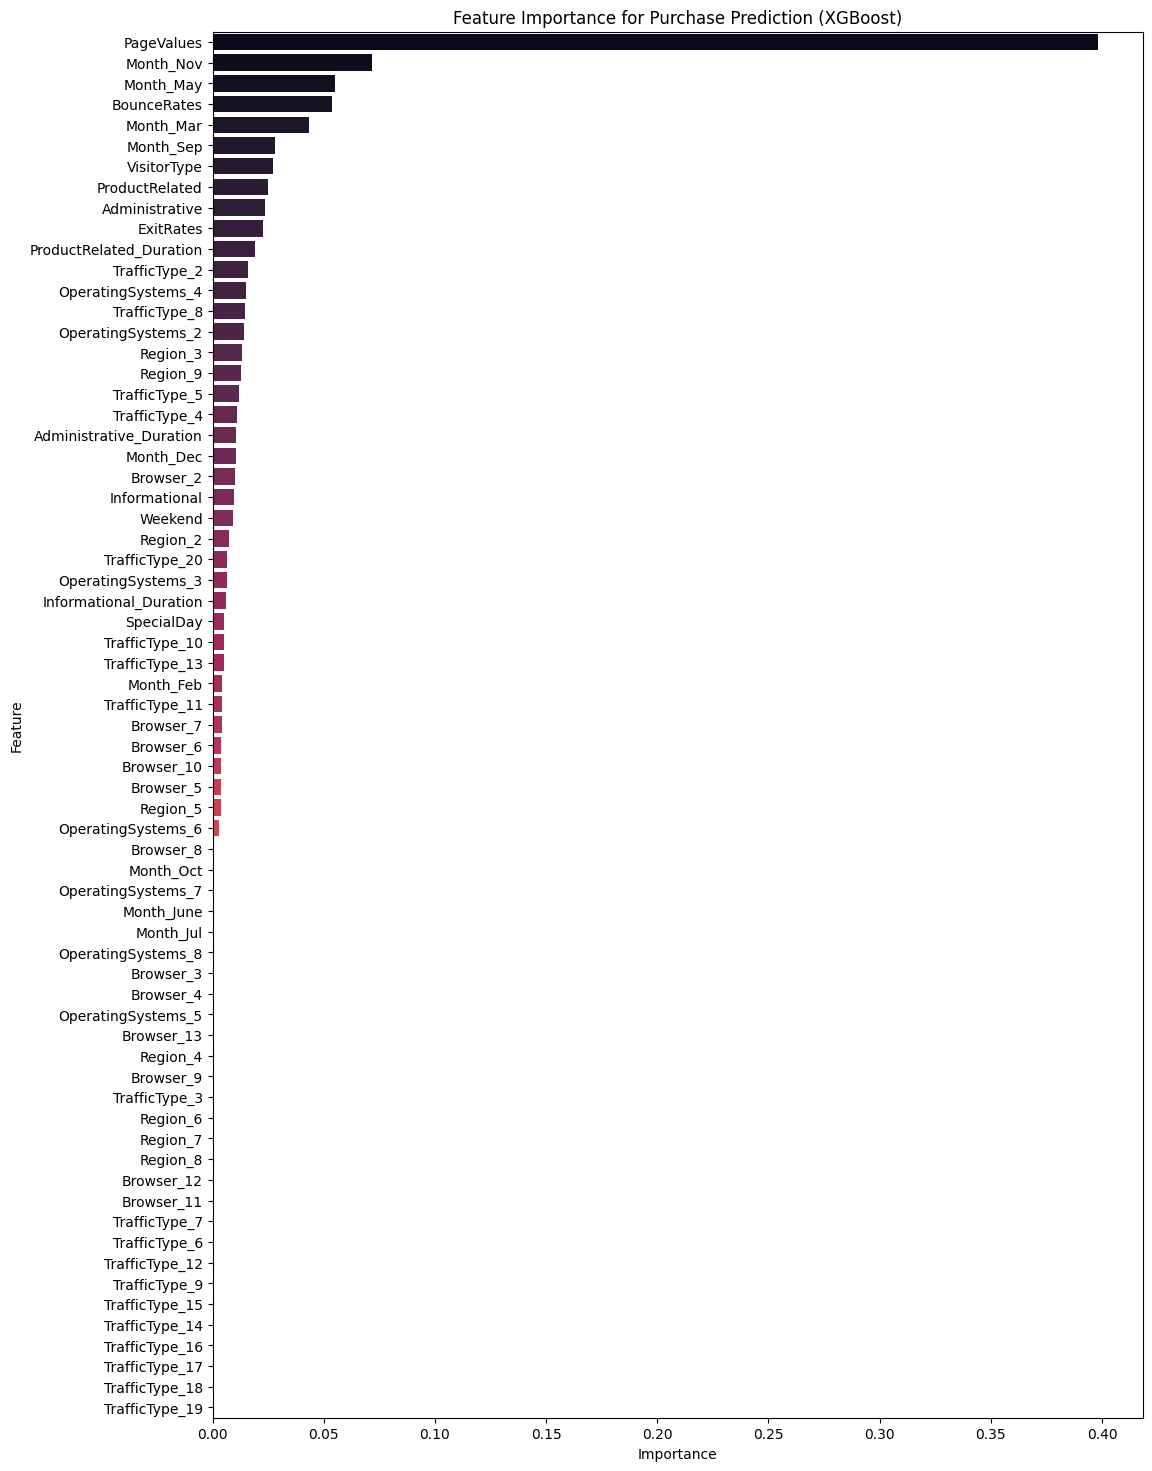

In [34]:
# Split the data into training and testing sets
print("Splitting data into training and testing sets (80/20 split)")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a binary classification model using XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Hyperparameter Tuning with GridSearchCV
print("Performing hyperparameter tuning with GridSearchCV")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print(f"Best parameters found:\n {grid_search.best_params_}")
print(f"Best ROC-AUC score:\n {grid_search.best_score_:.4f}")

# Step 4: Extract and visualize feature importance
feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 18))
sns.barplot(x=feature_importances.values, y=feature_importances.index, hue=feature_importances.index, palette='rocket', legend=False)
plt.title('Feature Importance for Purchase Prediction (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

4) Model Evaluation

Accuracy: 0.9015


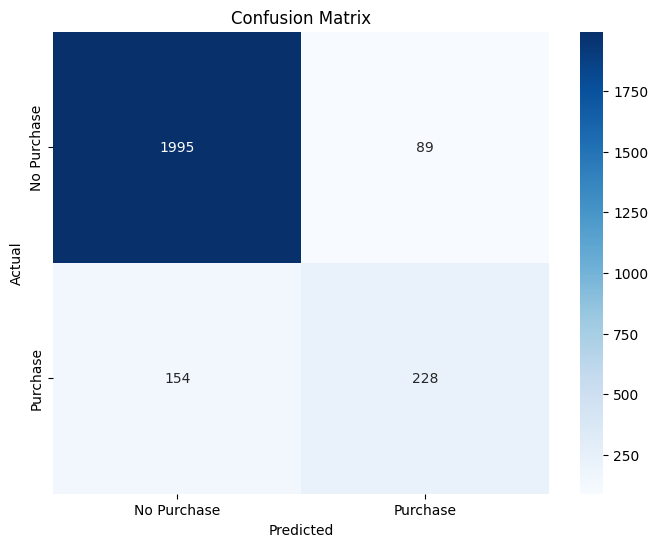

[[1995   89]
 [ 154  228]]


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.72      0.60      0.65       382

    accuracy                           0.90      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466


ROC-AUC Score: 0.9289


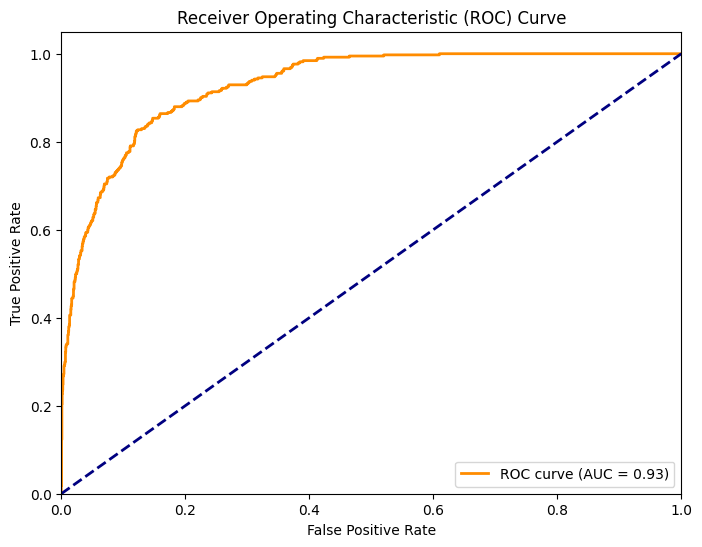

In [38]:
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(cm)

# Classification Report (Precision, Recall, F1-Score)
print("\n\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

5) Insights & Recommendations

Prioritize High-Value Pages: 

The PageValues feature was the single most important predictor of a purchase. 
The business should focus on optimizing the content, design, and user experience of these specific pages to further encourage conversions.

Optimize for Returning Visitors: 

Returning Visitors are the most likely to make a purchase. 
Personalized marketing efforts, targeted promotions, and a streamlined checkout process could significantly boost sales from this key customer segment.

Reduce Bounce and Exit Rates: 

High bounce and exit rates are strong indicators of a lost sale. The company should investigate pages with high rates to understand why users are leaving. 
Potential solutions include improving navigation, page load speed, or simplifying the user interface.

Leverage Seasonal Trends: 

The month of November was identified as a critical period. 
The company should strategically plan its promotions, advertising, and inventory to capitalize on the increased purchase intent during the holiday shopping season.